In [0]:
import json
import requests
import urllib

# 0. Preliminary step to get sample data



This preliminary step is reproducing Lorella's workflow Python file:
https://i-lab.public.data.uu.nl/vault-ocex/ChroniclItaly%20-%20Italian%20American%20newspapers%20corpus%20from%201898%20to%201920%5B1529330521%5D/original/
I just added a folder "data_1" to keep all files in one folder

In [82]:
mkdir 'data1'

mkdir: cannot create directory ‘data1’: File exists


In [0]:
# Base URL
chronam = 'https://chroniclingamerica.loc.gov/'

# Chronicling America search results
results = 'https://chroniclingamerica.loc.gov/search/pages/results/?date1=1880&date2=1920&searchType=advanced&language=ita&sequence=1&lccn=2012271201&lccn=sn85066408&lccn=sn85055164&lccn=sn85054967&lccn=sn88064299&lccn=sn84037024&lccn=sn84037025&lccn=sn86092310&proxdistance=5&state=California&state=District+of+Columbia&state=Massachusetts&state=Pennsylvania&state=Piedmont&state=Vermont&state=West+Virginia&rows=100&ortext=&proxtext=&phrasetext=&andtext=&dateFilterType=yearRange&page=11&sort=date'

# Count to keep track of downloaded files
count = 0

# Gets search results in JSON format
results_json = results + '&format=json'


In [0]:
# Returns JSON 
def get_json(url):
    data = requests.get(url)
    return(json.loads(data.content))
    
data = get_json(results_json)

In [0]:
files_list = []
# Cycle through JSON results
for page in data['items']:
    # Create URL
    hit = str(page['id'])
    seed = hit + 'ocr.txt'
    download_url = chronam + seed
 
    # Create file name
    file_name = download_url.replace('/', '_')
    files_list.append(file_name[41:])
    file_name = 'data1/' + file_name[41:]

    # Download .txt of the page
    urllib.request.urlretrieve(download_url, str(file_name))
    count += 1

# 1. Data preparation

## 1.1. Creating data frame
A dataframe is first created to keep the documents at their initial state, and the name of each file

In [0]:
import os
import pandas as pd

In [0]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [0]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open('data1/' + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [0]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

In [0]:
# variable containing the documents separately
corpus = sources['file_content']

In [0]:
# the 2 cells below shouldn't be useful anymore
# for verification purposes later, count the nr of characters for each content
#sources['file_len'] = sources['file_content'].apply(lambda x: len(x))
#sources['file_len'].sum()

In [0]:

# variable containing all documents together
#all_texts = ''
#for i in range(len(sources)):
#all_texts += sources['file_content'][i]
# check length
#len(all_texts)

## 1.2 Removing stop words, punctuation, short words

In [0]:
%%capture
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [0]:
# add tokenized documents in dataframe
sources['tokens'] = sources['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [0]:
# possible user options:
# .isalnum() to removes tokens that include numbers
# .isalpha() to removes all tokens that contain more than letters (punctuation and numbers)
# .isdecimal() to remove tokens that contain only decimals
# .isdigit() to remove tokens that contain only digits

# add new column in df with processed tokens (here: keeping only alpha tokens longer than 3 characters + lowercasing)
sources['doc_prep'] = sources['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalpha() and len(w) > 3 )])

In [0]:
from nltk.corpus import stopwords
ital_stopwords = stopwords.words('italian')

In [0]:
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [0]:
# spacy list of Stop words (seems to be more complete than NLTK)
# import spacy
# from spacy.lang.it.stop_words import STOP_WORDS
# spacy_it_sw = STOP_WORDS

In [0]:
# add column with tokenized documents without sw
sources['doc_prep_nostop'] = sources['doc_prep'].apply(lambda x: [w for w in x if not w in ital_stopwords])

## 1.3 Stem

In [0]:
from nltk.stem.snowball import SnowballStemmer

In [0]:
#initialize with needed language
stemmer = SnowballStemmer("italian")

In [0]:
# add column with stemmed tokens
sources['doc_stemmed'] = sources['doc_prep_nostop'].apply(lambda x: [stemmer.stem(w) for w in x])

## 1.4 Lemmatize

In [0]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [0]:
%%capture
!python -m spacy download it_core_news_sm

In [0]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [0]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [0]:
# add column with lemmatized tokens
sources['doc_lemmatized'] = sources['doc_prep_nostop'].apply(lambda x: lemmatize(x))

In [0]:
# variable with lemmatized tokens
lemmatized_corpus = sources['doc_lemmatized']

# 2. Topics with LDA

In [0]:
#Gensim installation
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA



### 2.1.1 Bag of words

In [0]:
# dataset = [d.split() for d in lemmatized_corpus] (this is not useful if lemmatized version is used)
# Create Dictionary
# change "lemmatized_corpus" variable by stemmed_corpus or tokenized_corpus_without_sw depending
# on which version you would like to work with 
id2word = corpora.Dictionary(lemmatized_corpus)
corpus = [id2word.doc2bow(text) for text in lemmatized_corpus]

In [0]:
# list of words and occurence per document
words = []
frequency = []

for cp in corpus:
  word_id = list(cp[0])[0]
  words.append(id2word[list(cp[0])[0]])
  frequency.append(list(cp[0])[1])

In [0]:
words_frequency = pd.DataFrame(list(zip(words, frequency)), columns=['word', 'frequency'])

In [0]:
# sort descending
# words_frequency.sort_values(by=['frequency'], ascending=False)[:10]

## 2.2 LDA

In [0]:
# set the number of topics here
numtopics = 8

In [0]:
ldagensim = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics, iterations = 400, chunksize = 2000, passes = 20)

In [109]:
ldagensim.print_topics()

[(0,
  '0.005*"italiano" + 0.004*"stare" + 0.003*"fare" + 0.003*"dire" + 0.003*"italia" + 0.003*"dispaccio" + 0.003*"potere" + 0.003*"altro" + 0.003*"egli" + 0.003*"dovere"'),
 (1,
  '0.009*"italiano" + 0.005*"roma" + 0.005*"italia" + 0.004*"dispaccio" + 0.004*"stare" + 0.004*"fare" + 0.004*"altro" + 0.004*"telegrafico" + 0.003*"dire" + 0.003*"nuovo"'),
 (2,
  '0.006*"italiano" + 0.005*"stare" + 0.004*"dispaccio" + 0.003*"potere" + 0.003*"anno" + 0.003*"fare" + 0.003*"italia" + 0.003*"altro" + 0.003*"telegrafico" + 0.003*"stato"'),
 (3,
  '0.001*"esposizione" + 0.001*"young" + 0.001*"galleria" + 0.001*"avellino" + 0.001*"fenomeno" + 0.001*"moody" + 0.001*"prinettl" + 0.001*"decorativo" + 0.001*"passerella" + 0.001*"valle"'),
 (4,
  '0.005*"stare" + 0.004*"italiano" + 0.004*"fare" + 0.003*"anno" + 0.003*"altro" + 0.003*"mila" + 0.003*"italia" + 0.003*"milione" + 0.003*"dispaccio" + 0.003*"potere"'),
 (5,
  '0.004*"potere" + 0.003*"stare" + 0.003*"tutto" + 0.003*"sociale" + 0.003*"cosa" 

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [0]:
from gensim.models.coherencemodel import CoherenceModel

In [111]:
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()
print('\nCoherence Score LDA Gensim: ', coherence_ldagensim)


Coherence Score LDA Gensim:  0.28093149442495846


## 2.4 Coherence and number of topics

In [0]:
#can take a long time to run
%%capture
topics_nr = []
coherence_values_gensim = []
for num_topics in range(2, 20):
  model = models.LdaModel(corpus, id2word=id2word, num_topics=num_topics, iterations = 400, chunksize = 2000, passes = 20)
  coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_gensim.append(coherence_value)
  topics_nr.append(str(num_topics))

In [114]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_gensim[i],4))

Num Topics = 2  has Coherence Value of 0.2616
Num Topics = 3  has Coherence Value of 0.2596
Num Topics = 4  has Coherence Value of 0.2568
Num Topics = 5  has Coherence Value of 0.2806
Num Topics = 6  has Coherence Value of 0.3064
Num Topics = 7  has Coherence Value of 0.2883
Num Topics = 8  has Coherence Value of 0.303
Num Topics = 9  has Coherence Value of 0.2658
Num Topics = 10  has Coherence Value of 0.277
Num Topics = 11  has Coherence Value of 0.2654
Num Topics = 12  has Coherence Value of 0.2683
Num Topics = 13  has Coherence Value of 0.3214
Num Topics = 14  has Coherence Value of 0.2782
Num Topics = 15  has Coherence Value of 0.3066
Num Topics = 16  has Coherence Value of 0.3442
Num Topics = 17  has Coherence Value of 0.2706
Num Topics = 18  has Coherence Value of 0.3073
Num Topics = 19  has Coherence Value of 0.2808


In [0]:
# Visualize coherence scores
import matplotlib.pyplot as plt

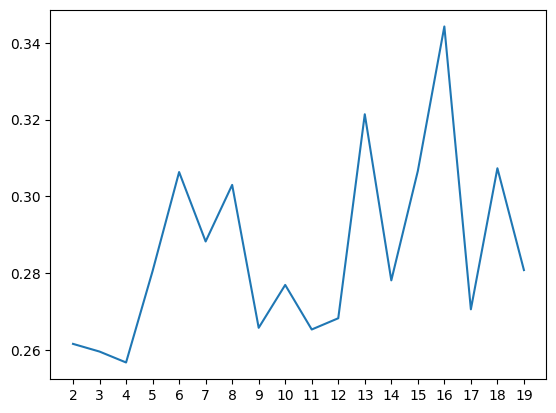

In [116]:
plt.plot(topics_nr, coherence_values_gensim)

In [0]:
# To analyse the results, the user can print the list of topics for different topic nr

In [0]:
# print topics for nr of topics = 8
%%capture
numtopics = 8
model = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics, iterations = 400, chunksize = 2000, passes = 20)

In [119]:
model.print_topics()

[(0,
  '0.005*"italiano" + 0.003*"papa" + 0.003*"potere" + 0.003*"roma" + 0.003*"dire" + 0.003*"anno" + 0.003*"italia" + 0.003*"stare" + 0.003*"grande" + 0.003*"giorno"'),
 (1,
  '0.007*"italiano" + 0.005*"dispaccio" + 0.004*"stare" + 0.004*"italia" + 0.004*"telegrafico" + 0.003*"fare" + 0.003*"roma" + 0.003*"nuovo" + 0.003*"altro" + 0.003*"dire"'),
 (2,
  '0.008*"italiano" + 0.004*"giornale" + 0.004*"stare" + 0.004*"fare" + 0.004*"anno" + 0.004*"italia" + 0.003*"altro" + 0.003*"potere" + 0.003*"roma" + 0.003*"primo"'),
 (3,
  '0.008*"italiano" + 0.006*"cardinale" + 0.004*"fare" + 0.004*"stare" + 0.004*"altro" + 0.003*"roma" + 0.003*"primo" + 0.003*"papa" + 0.003*"potere" + 0.003*"italia"'),
 (4,
  '0.007*"italiano" + 0.004*"dispaccio" + 0.004*"stare" + 0.003*"dire" + 0.003*"telegrafico" + 0.003*"potere" + 0.003*"altro" + 0.003*"italia" + 0.003*"fare" + 0.003*"primo"'),
 (5,
  '0.001*"edoardo" + 0.001*"regalare" + 0.001*"strenna" + 0.001*"madre" + 0.001*"abbonare" + 0.001*"moreno" + 0.

# Topic visualisation

In [0]:
%%capture
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/jscode-test-2.js
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_gensim.py

In [0]:
# Number of terms to display stats for
R = 30

In [0]:
%run -i tm1_gensim.py

In [0]:
%%capture
import notebook.nbextensions
notebook.nbextensions.install_nbextension('topic_info.csv', user=True)
notebook.nbextensions.install_nbextension('topic_proportion.csv', user=True)

In [0]:
from IPython.display import display, HTML
from IPython.core.display import Javascript

In [135]:
display(HTML('<style>@import url("https://fonts.googleapis.com/css2?family=Fira+Sans:wght@300&display=swap");#vis_tm_1{width:40%; margin-left:20%}.svg-container{position:relative;width:100%;vertical-align:top;overflow:hidden;margin:0;padding:0;}.svg-content-responsive{margin:0;padding:0;display:inline-block;position:absolute;top:0;left:0}.line_style{stroke:"rgb(70, 130, 180,.3)";stroke-width:1}.svg_h1{font-size:.9em}.svg_h1,.svg_h2{font-family:"Fira Sans",Arial}.svg_h2{font-size:.6em}.svg_text{font-size:.8em}.svg_text,.svg_text_2{font-family:"Fira Sans",Arial}.svg_text_2{font-size:.7em}.svg_text_3{font-family:"Fira Sans";font-size:.6em}.select_box{width:30%;padding-left:1em;font-family:"Fira Sans",Arial}.select_box select{width:100%;background-color:#fff;padding:.5em .6em;box-shadow:inset 0 1px 3px #ddd;vertical-align:middle;font-family:"Fira Sans",Arial,sans-serif;letter-spacing:.01em;line-height:1.15;-webkit-writing-mode:horizontal-tb!important;text-rendering:auto;color:#000;letter-spacing:normal;word-spacing:normal;text-transform:none;text-indent:0;text-shadow:none;display:inline-block;text-align:start;-webkit-appearance:menulist;align-items:center;white-space:pre;-webkit-rtl-ordering:logical;background-color:#f8f8f8;cursor:default;margin:0;font:400 11px system-ui;border-radius:5px;border:1px solid #a6a6a6;border-image:none;border-image:initial}.select_box select:focus{border-color:#fff;outline:0;box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 1px rgba(102,175,233,.2)}</style>'))
display(HTML('<div id="vis_tm_1"></div>'))
Javascript(filename='jscode-test-2.js')

<IPython.core.display.Javascript object>

# Topic distribution

## 3.1. Distribution per topic and per document

In [0]:
%%capture
ldamodel = model

In [0]:
doc_topic_weights = ldamodel.inference(corpus)[0]
doc_topic_dists = doc_topic_weights / doc_topic_weights.sum(axis=1)[:, None]

In [0]:
distribution_gensim = pd.DataFrame(doc_topic_dists,columns=[f'topic{i}' for i in range(numtopics)])

In [0]:
distribution_gensim.index.name = 'document'

In [126]:
# add file names
distribution_gensim_wfiles = distribution_gensim.copy()
distribution_gensim_wfiles.insert(0, 'document_path', sources['file_name'])
distribution_gensim_wfiles

,document_path,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
document,,,,,,,,,
0,sn85066408_1903-04-27_ed-1_seq-1_ocr.txt,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.999451,0.000078
1,sn85066408_1903-04-28_ed-1_seq-1_ocr.txt,0.000070,0.999513,0.000070,0.000070,0.000070,0.000070,0.000070,0.000070
2,sn85066408_1903-04-29_ed-1_seq-1_ocr.txt,0.000093,0.000093,0.000093,0.000093,0.000093,0.301042,0.698402,0.000093
3,sn85066408_1903-04-30_ed-1_seq-1_ocr.txt,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.999301
4,sn85066408_1903-05-01_ed-1_seq-1_ocr.txt,0.000150,0.000150,0.998950,0.000150,0.000150,0.000150,0.000150,0.000150
...,...,...,...,...,...,...,...,...,...
95,sn85066408_1903-08-05_ed-1_seq-1_ocr.txt,0.000289,0.703071,0.000289,0.295195,0.000289,0.000289,0.000289,0.000289
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.999400,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086
97,sn85066408_1903-08-07_ed-1_seq-1_ocr.txt,0.000076,0.000076,0.000076,0.999466,0.000076,0.000076,0.000076,0.000076


## 3.2. Distribution per topic for the whole corpus

In [0]:
sources['doc_length'] = sources['doc_lemmatized'].apply(lambda x: len(x))

In [0]:
topic_frequency = distribution_gensim.mul(sources['doc_length'], axis=0).sum()

In [0]:
topic_proportion = (topic_frequency / topic_frequency.sum()*100).sort_values(ascending=False)

In [139]:
topic_proportion

topic6    30.102854
topic3    16.242291
topic1    15.459078
topic4    14.312636
topic0     9.252872
topic2     7.793541
topic7     6.548961
topic5     0.287766
dtype: float64

In [0]:
# dataframe with values to sort them by order of importance
distribution_df_gensim = pd.DataFrame(topic_proportion, columns=['weight'])

In [0]:
distribution_df_gensim.index.name = "topics"

In [0]:
topics = distribution_df_gensim.index.array

Text(0.5, 0, 'Weight (%)')

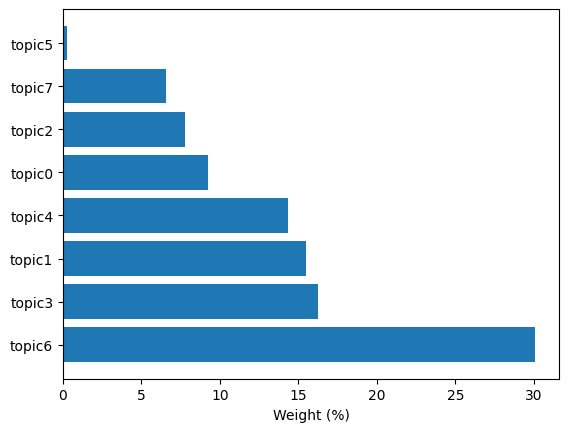

In [144]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(topics, distribution_df_gensim['weight'], align='center')
ax.set_xlabel('Weight (%)')

# Topics weight over time

## 4.1 Aggregate document weights

In [0]:
# grouping data per month

In [0]:
import re

In [0]:
# function to retrieve date from file name
def get_date(file):
  date_match = re.findall(r'_(\d{4}-\d{2}-\d{2})_',file)
  return date_match[0]

# function to retrieve year from file name
def get_year(file):
  year_match = re.findall(r'_(\d{4})-\d{2}-\d{2}_',file)
  return year_match[0]

# function to retrieve month from file name
def get_month(file):
  month_match = re.findall(r'_\d{4}-(\d{2})-\d{2}_',file)
  return month_match[0]

In [0]:
distribution_gensim_wfiles['date'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_date(x))
distribution_gensim_wfiles['year'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_year(x))
distribution_gensim_wfiles['month'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_month(x))

In [0]:
gensim_groupby = distribution_gensim_wfiles.copy()

In [0]:
# drop columns that won't be needed at this stage
gensim_groupby = gensim_groupby.drop(['document_path', 'date'], axis=1)

In [0]:
# group by year and month 
distribution_month = gensim_groupby.groupby(['year','month']).mean().reset_index()

In [151]:
distribution_month

,year,month,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
0,1903,04,0.000085,0.249946,0.000085,0.000085,0.000085,0.075322,0.424506,0.249885
1,1903,05,0.105906,0.192255,0.115380,0.124888,0.153822,0.000088,0.230697,0.076965
2,1903,06,0.033382,0.232660,0.000089,0.100030,0.166629,0.000089,0.467031,0.000089
3,1903,07,0.154479,0.033674,0.130392,0.216352,0.162622,0.001433,0.235142,0.065906
4,1903,08,0.222189,0.078204,0.000117,0.365963,0.000117,0.000117,0.222126,0.111167


## 4.2 Monthly average of normalized weight per topic

### 4.2.1. Line chart view 

In [0]:
import seaborn as sns

In [0]:
#restructuring df so that it can work with seaborn
df_vis = pd.DataFrame(columns=['time', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_month.columns)-2
for i in range(len(distribution_month)):
  for j in range(columns_nr):
    df_vis.loc[x] = ''
    df_vis['time'].loc[x] = distribution_month['month'].loc[i] + '/' + distribution_month['year'].loc[i]
    df_vis['topic_id'].loc[x] = distribution_month.columns[j+2]
    df_vis['distribution'].loc[x] = distribution_month.iloc[i,(j+2)]
    x+= 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


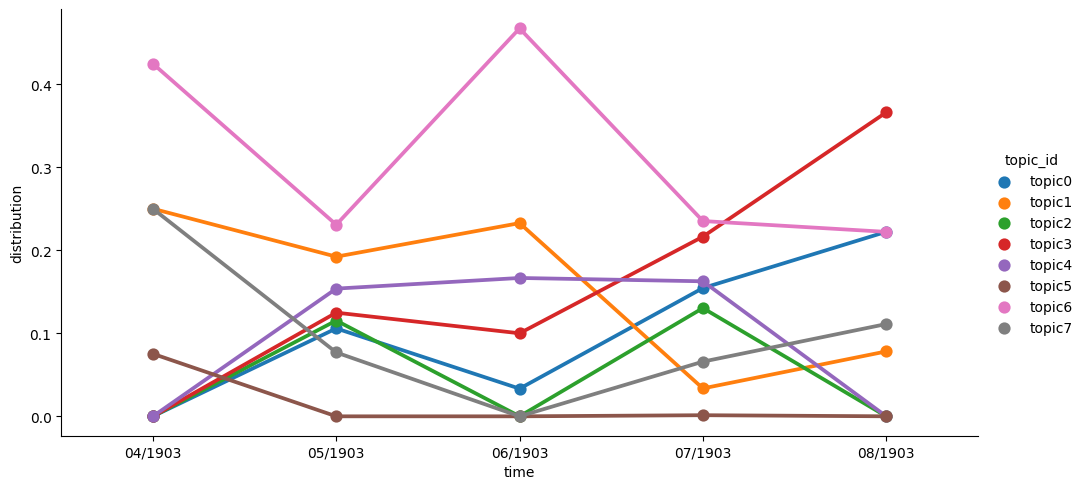

In [154]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.3. Bar chart view

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


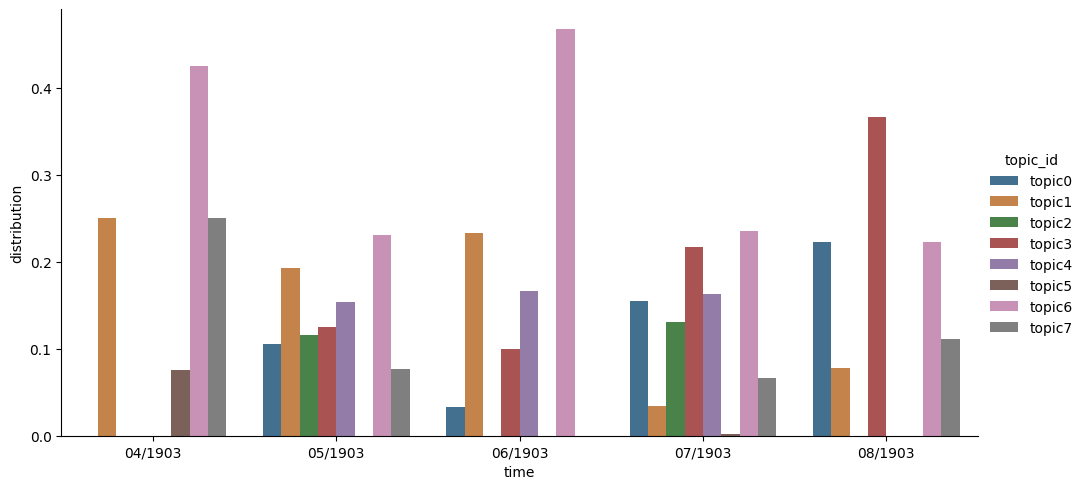

In [155]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               kind= 'bar',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.4 Normalized proportions of topic weights per title

In [0]:
# function to retrieve publication ref from file name
def get_ref(file):
  ref_match = re.findall(r'(\w+\d+)_\d{4}-\d{2}-\d{2}_',file)
  return ref_match[0]

In [0]:
distribution_gensim_wfiles['publication'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_ref(x))

In [158]:
distribution_gensim_wfiles

,document_path,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,date,year,month,publication
document,,,,,,,,,,,,,
0,sn85066408_1903-04-27_ed-1_seq-1_ocr.txt,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.999451,0.000078,1903-04-27,1903,04,sn85066408
1,sn85066408_1903-04-28_ed-1_seq-1_ocr.txt,0.000070,0.999513,0.000070,0.000070,0.000070,0.000070,0.000070,0.000070,1903-04-28,1903,04,sn85066408
2,sn85066408_1903-04-29_ed-1_seq-1_ocr.txt,0.000093,0.000093,0.000093,0.000093,0.000093,0.301042,0.698402,0.000093,1903-04-29,1903,04,sn85066408
3,sn85066408_1903-04-30_ed-1_seq-1_ocr.txt,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.999301,1903-04-30,1903,04,sn85066408
4,sn85066408_1903-05-01_ed-1_seq-1_ocr.txt,0.000150,0.000150,0.998950,0.000150,0.000150,0.000150,0.000150,0.000150,1903-05-01,1903,05,sn85066408
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,sn85066408_1903-08-05_ed-1_seq-1_ocr.txt,0.000289,0.703071,0.000289,0.295195,0.000289,0.000289,0.000289,0.000289,1903-08-05,1903,08,sn85066408
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.999400,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,1903-08-06,1903,08,sn85066408
97,sn85066408_1903-08-07_ed-1_seq-1_ocr.txt,0.000076,0.000076,0.000076,0.999466,0.000076,0.000076,0.000076,0.000076,1903-08-07,1903,08,sn85066408


In [0]:
gensim_groupby2 = distribution_gensim_wfiles.copy()

In [0]:
distribution_title = gensim_groupby2.groupby(['publication']).mean().reset_index()

In [161]:
distribution_title

,publication,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
0,2012271201,0.178978,0.004301,0.004301,0.170854,0.104183,0.004301,0.528781,0.004301
1,sn85066408,0.097268,0.163144,0.077812,0.161560,0.144434,0.003430,0.285642,0.066710


In [0]:
#restructuring df so that it can work with seaborn
df_vis2 = pd.DataFrame(columns=['publication', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_title.columns)-1
for i in range(len(distribution_title)):
  for j in range(columns_nr):
    df_vis2.loc[x] = ''
    df_vis2['publication'].loc[x] = distribution_title['publication'].loc[i]
    df_vis2['topic_id'].loc[x] = distribution_title.columns[j+1]
    df_vis2['distribution'].loc[x] = distribution_title.iloc[i,(j+1)]
    x+= 1

In [163]:
df_vis2

,publication,topic_id,distribution
0,2012271201,topic0,0.178978
1,2012271201,topic1,0.00430095
2,2012271201,topic2,0.00430095
3,2012271201,topic3,0.170854
4,2012271201,topic4,0.104183
5,2012271201,topic5,0.00430084
6,2012271201,topic6,0.528781
7,2012271201,topic7,0.00430093
8,sn85066408,topic0,0.0972679
9,sn85066408,topic1,0.163144


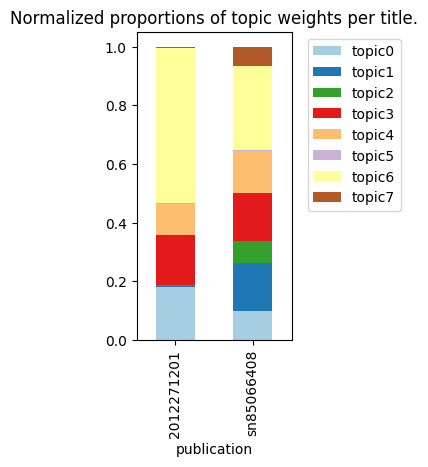

In [164]:
df_vis2.pivot('publication','topic_id', 'distribution')\
.plot(kind='bar', stacked=True, colormap='Paired', 
      figsize=(2,4), title='Normalized proportions of topic weights per title.')\
.legend(bbox_to_anchor=(1.75, 1))